In [1]:
# INIT
!pip install transformers datasets torch tensorflow sentencepiece numpy pandas -q

import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_built():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# 2.텍스트 분류 (Text Classification)

* 텍스트 분류는 자연어 처리의 가장 대표적인 문제이다.
* 텍스트 분류는 텍스트를 입력으로 받아, 텍스트가 어떤 종류의 범주에 속하는지를 구분하는 문제이다.
  예를 들어 스팸 메일 분류기는 이메일을 입력으로 받아 스팸 메일인지 아닌지를 구분한다. 또한 영화 리뷰 분류기는 영화 리뷰를 입력으로 받아 리뷰가 긍정적인지 부정적인지를 구분한다.

*트랜스포머 모델을 훈련하는 전형적인 파이프라인*
```mermaid
graph LR
    S1[데이터셋]
    S2[토크나이저]
    S3[트랜스포머스]
    S4[데이터셋]

    S1 -->|데이터셋 로드하고 전처리하기| S2
    S2 -->|토크나이저로 토큰화하고 인코딩하기| S3
    S3 -->|트랜스포머 모델 훈련하기| S4
    S4 -->|훈련된 모델로 텍스트 분류하기| S5
```

## 2.1. 데이터셋

영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 분류하는 감정 분류기를 만든다.
감정은 분노(angry), 혐오(disgust), 두려움(fear), 기쁨(joy), 슬픔(sadness), 놀람(surprise)의 여섯 개 감정으로 분류한다.

In [2]:
# 허깅페이스 데이터셋 로드
from datasets import list_datasets

all_datasets = list_datasets()
print("현재 허브에는 {}개의 데이터셋이 있습니다.\n".format(len(all_datasets)))

/var/folders/k2/fbzjm6cn4_1_7pdkyg78h17m0000gn/T/ipykernel_5392/3753559272.py:4: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 102048개의 데이터셋이 있습니다.



In [3]:
# emotion 데이터셋 로드
from datasets import load_dataset
emotions = load_dataset('emotion')
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
# 한 개의 행이 하나의 딕셔너리로 구성되어 있다. 키는 'label'과 'text'이다.
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
# 키를 이용해 값을 가져올 수 있다.
train_ds.column_names

['text', 'label']

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [8]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### 2.1.2. 데이터셋에서 데이터프레임 만들기


In [9]:
import pandas as pd

emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
# 레이블을 숫자에서 문자로 변환
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

# 레이블명 컬럼 추가
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3. 클래스 분포 확인

* 텍스트 분류 문제를 풀 때는 데이터셋의 클래스 분포를 확인하는 것이 중요하다.
* 클래스 분포가 평향된 데이터셋은 훈련 손실과 평가 지표 측면에서 균형 잡힌 데이터셋과 다른 처리법이 필요하다.

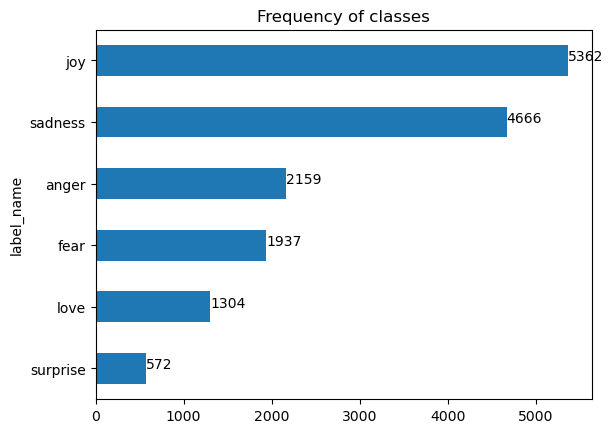

In [11]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
# with label counts
for index, value in enumerate(df['label_name'].value_counts(ascending=True)):
  plt.text(value, index, str(value))
plt.title("Frequency of classes")
plt.show()

이 데이터셋은 불균형이 심하다. joy와 sadness 클래스가 ㅁ낳이 등장하고 love와 surprise 클래스는 5~10배 정도 적게 등장한다.

불균형한 데이터는 다음 방법을 사용해 균형을 맞출 수 있다.

* 소수 클래스를 랜덤하게 오버샘플링 한다.
* 다수 클래스를 랜덤하게 언더샘플링 한다.
* 클래스의 대표성이 부족하다면 레이블된 데이터를 더 많이 수집한다.

### 2.1.4. 트위 길이 확인

* 트랜스포머 모델은 *최대 문맥 크기(maximum context size)*라는 최대 입력 시퀀스 길이가 있다.
* DistilBERT 모델의 최대 문맥 크키는 512토큰으로 문단 몇개 정도가 된다.
* 트윗당 단어 분포를 보면 감정에 따른 트위 길이가 대략 추정된다.

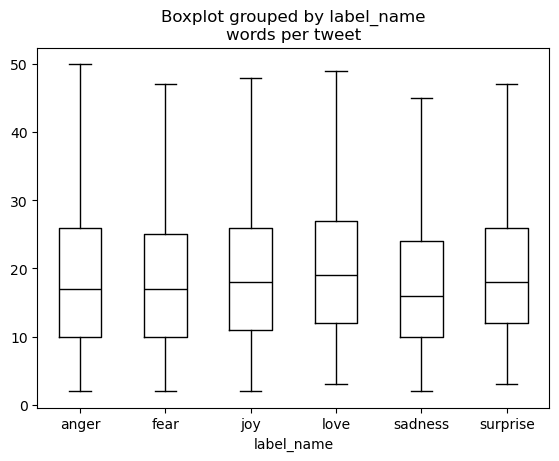

In [12]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name', grid=False, showfliers=False, color='black')

plt.show()

* 각 감정의 트윗 길이는 15개 단어 정도이다.
* 가장 긴 트윗도 DistilBERT의 최대 문맥 크기보다 더 작다.

In [13]:
emotions.reset_format()

## 2.2.텍스트에서 토큰으로

* DistilBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못한다.

**토큰화 방법**

1. 문자 토큰화
2. 단어 토큰화
3. 부분단어 토큰화

### 2.2.1. 문자 토큰화

In [14]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [15]:
# 수치화
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [16]:
# 어휘 사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


각 토큰이 고유한 숫자 식별자로 매핑된다.

In [17]:
categorical_df = pd.DataFrame({"Name":["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0, 1, 2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [18]:
# 원 핫 백터로 변환
pd.get_dummies(categorical_df, columns=["Label ID"])

,Name,Label ID_0,Label ID_1,Label ID_2
0,Bumblebee,True,False,False
1,Optimus Prime,False,True,False
2,Megatron,False,False,True


**하나의 항목만 1이고 나머지는 0인 벡터로 변환**을 원-핫 벡터라고 한다.
벡터의 두 원소가 1이면 해당하는 토큰이 동시에 존재한다는 의미이다.

In [19]:
# pytorch input_ids를 텐서로 바꾸고 one_hot()함수를 이용해 원 핫 인코딩을 만든다.
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

38개의 입력 토큰 각각에 20 차원의 원-핫 벡터가 만들어 진다.

어휘사전을 구성하는 고유한 문자가 20개이기 때문이다.

In [20]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원 핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원 핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### 2.2.2. 단어 토큰화

* 텍스트를 문자가 아니라 단어로 분할하고 각 단어를 정수로 매핑한다.
* 단어 토큰화는 처음부터 단어를 사용하기 때문에 문자에서 단어를 학습하는 단계가 생략되어 훈련 과정의 복잡도가 감소한다.

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


문자 수준 토큰화에서 수행한 단계를 동일하게 적용해 각 단어를 하나의 ID에 매핑한다.
**구두점을 제거하고 모든 문자를 소문자로 변환**한다.

### 2.2.3. 부분단어 토큰화

기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 형태이다. 드믈게 등장하는 단어를 더 작은 단위로 나누면 모델이 복잡한 단어나 철차 오류를 처리하기 용이하다.
또한 입력 길이를 적절한 크기로 유지하기 위해 자주 등장하는 단어를 고유한 항목으로 유지한다. 부분단어 토큰화는 통계 규칙과 알고리즘 을 함께 사용해 사전 훈련 말뭉치에서 학습한다.

In [22]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [23]:
# AutoTokenizer클래스는 체크포인트 이름을 사용해 모델의 설정, 사전 훈련된 가중치, 어휘사전을 자동으로 추출하는 자동 클래스 이다.
# 이 클래스를 사용하면 모델 간의 빠른 전환이 가능하지만, 특정 클래스를 수동으로 로드할 수도 있다.

# DisstilBERT 토크나이저 로드

from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [24]:
import json
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


문자 토큰화처럼 단어가 input_ids 필드에 있는 고유한 정수에 매핑된다.

In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


* [CLS], [SEP]가 시퀀스 처음과 끝에 추가된다.
  이런 토큰은 모델마다 다르며, 시퀀스의 시작과 끝을 나타낸다.
* 모든 토큰이 소문자로 변환된다.
* `tokenizing`, `NLP`가 각각 2개의 토큰으로 분할된다.
  자주 등장하는 단어가 아니기 때문에 `###izing`, `##p`에 있는 #는 앞의 문자열이 공백이 아님을 나타낸다.
  이런 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 합쳐진다.


In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [27]:
# 어휘 사전의 크기 확인
tokenizer.vocab_size

30522

In [28]:
# 모델의 최대 문맥 크기 확인
tokenizer.model_max_length

512

### 2.2.4. 전체 데이터셋 토큰화

전체 말뭉치를 토큰화하기 위해서`DatasetDict`객채의 `map`메서드를 사용한다.

In [29]:
def tokenize(batch):
  # padding=True 로 설정하면 배치에 있는 가장 긴 샘플 크기에 맞춰 심플을 0으로 패딩한다.
  # truncation=True 로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.
  return tokenizer(batch['text'], padding=True, truncation=True)

# 확인

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


첫번째 문장이 두번째 문자보다 길이가 짧다. 이런 경우에는 두번째 문장을 첫번째 문장의 길이에 맞추기 위해 패딩을 추가한다.
여기서 패딩은 0으로 채워진 토큰이다. 어휘사전에는 [PAD]에 해당한다.

In [30]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 2.3. 텍스트 분류 모델 훈련하기

DistilBERT 같은 모델은 텍스트 시퀀스에 있는 마스킹된 단어를 예측하도록 사전 훈련된다. 하지만 이런 언어 모델은 텍스트 분류에 바로 사용하지 못한다. 

DistilBERT 같은 인코더 기반 모델의 구조

1. 텍스트를 토큰화해 토큰 인코딩이라 부르는 `원-핫 벡터`로 변환한다.
2. 토큰 인코딩을 저차원 공간의 벡터인 `토큰 임베딩`으로 변환한다.
3. 토큰 임베딩을 `인코더 블록`층에 통과시켜 각 입력 토큰에 대한 은닉 상태를 만든다.
4. 각 은틱 상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해 입력 토큰을 예측하는 층으로 전달된다.
5. 분류 작업에서는 이 언어 모델링층을 분류층으로 변환한다.

*특성추출*

사전 훈련된 모델을 수정하지 않고 은닉 상태를 특성으로 사용해 분류모델을 훈련

*미세튜닝*

사전 훈련된 모델의 파라미터도 업데이트하기 위해 전체 모델을 `엔드-투-엔드`로 훈련한다.

### 2.3.1. 트랜스포머를 특성 추출기로 사용하기

트랜스포머는 특성 추출기로 사용하기 편하다. 트랜스포머는 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용한다.

이 방식은 작거나 얕은 모델을 빠르게 훈련한다.

**사전 훈련된 모델 사용하기**

트랜스포머의 `AutoModel`은 `AutoTokenizer`와 비슷하게 사전 훈련된 가중치를 로드하는 `from_pretrained`메서드를 제공한다.

In [31]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
device = 'mps'
model = AutoModel.from_pretrained(model_ckpt).to(device)

**마지막 은닉 상태 추출하기**

문자열을 인코딩하고 토큰을 파이토치 텐서로 변환한다. `return_tensors=pt` 매개변수를 지정해 텐서를 반환한다.

In [32]:
text = "tis is a text"

inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기 : {inputs['input_ids'].size()}")

입력 텐서 크기 : torch.Size([1, 6])


In [33]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad(): # 그래디언트 계산 비활성화
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2813, -0.0133, -0.0027,  ..., -0.0250,  0.2942,  0.4156],
         [ 0.1336,  0.0050,  0.1602,  ..., -0.1087,  0.2122,  0.2309],
         [-0.4235, -0.0403, -0.0102,  ..., -0.0084,  0.2893,  0.5059],
         [-0.2621,  0.1676, -0.0322,  ...,  0.0156,  0.2477,  0.5456],
         [ 0.0673, -0.0499,  0.0510,  ...,  0.1647,  0.2482,  0.0714],
         [ 0.7788,  0.2633, -0.3072,  ...,  0.1292, -0.7722, -0.0995]]],
       device='mps:0'), hidden_states=None, attentions=None)


In [34]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

은닉 상태 텐서의 크기는 [batch_size, n_nokens, hidden_dim]이다. 

6개의 입력 토큰마다 768차원의 벡터를 반환한다.

In [35]:
# 마지막 은닉 상태를 얻는 방법
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [36]:
def extract_hidden_states(batch):
  # 모델 입력을 GPU로 이동
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  # 마지막 은닉 상태를 얻는다.
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # [CLS]토큰에 대한 벡터를 반환한다.
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [37]:
# 이 모델은 텐서가 입력되기를 기대하므로 input_ids와 attention_mask 열을 "torch" 포멧으로 변경한다.
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [38]:
# 모든 분할에 대해 은닉 상태를 한번에 추출한다.
# batch_size=None으로 지정하지 않았기 때문에 기본값 1000이 사용된다.
# 기대한 대로 extract_hidden_states() 함수를 적용하면 새로운 hidden_state 열이 데이터셋에 추가된다.
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"].column_names

**특성 행렬 마들기**

전처리된 데이터셋에 분류 모델을 훈련하는데 필요한 모든 정보가 담겨있다.

은닉 상태를 입력 특성으로 사용하고 레이블을 타깃으로 사용한다.

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

은닉 상태로 모델을 훈련하기 전에 분류하려는 감저엥 대한 융여한 표현을 제공하는지 확인한다.

**훈련 세트 시각화하기**

768차원의 은닉상태를 시각화하기는 어렵기 때문에 UMAP 알고리즘을 사용해서 이 벡터를 2차원으로 줄인다.


In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0, 1]로 조정한다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련한다.
mapper = UMAP(n_components=2, metric='cosine', random_state=42).fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

출력 결과는 훈련 샘플과 개수가 동일한 배열이다. 하지만 특성은 768개가 아니라 2개 이다.

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

**간단한 분류 모델 훈련하기**

은닉 상태가 감정별로 조금씩 다르지만 일부 감정 사이에는 명확한 경계가 없기도 하다.

이 은닉 상태를 사용해 사이킷런의 로지스틱 회귀 모델을 훈련한다.

In [ ]:
from sklearn.linear_model import LogisticRegression

# 수렴을 보장하기 위해 `max_iter`를 증가 시킨다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

사이킷런의 DummyClassifier와 비교해 보면 DistilBERT 임베딩을 사용한 간단한 분류 모델은 기준 모델보다 훨씬 높은 정확도를 달성한다.

**오차 행렬 시각화하기**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

`anger`와 `fear`는 `sadness`와 가장 많이 혼동된다.

`love`와 `surprise`는 `joy`로 많이 오인된다.

### 2.3.2 트랜스포머 미세 튜닝하기

미세 튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고 전체 모델을 훈련한다.

이를 위해 분류 헤드는 미분이 가능해야한다. 따라서 이 방식은 신경망으로 분류 작업을 수행한다.

분류 모델에 입력으로 사용하는 은닉 상태를 훈련하면 분류 작업에 적합하지 않은 데이터를 다룰다는 문제를 회피할 수 있다.

초기 은식 상태는 훈련하는 동안에 모델 손실이 감소하도록 수정되고 성능이 높아진다.

**사전 훈련된 모델 로드하기**

1. 사전 훈련된 DistilBERT 모델
2. 

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

모델 일부가 랜덤하게 초기화된다는 경고가 발생한다. 이 경고는 모델의 일부가 사전 훈련된 가중치로 초기화되지 않았다는 것을 의미한다.
정상적인 동작이다.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  """
  
  """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

**모델 훈련하기**

훈련 파라미터를 정의하기 위해 `TrainingArguments`클래스를 사용한다. 이 클래스는 많은 정보를 저장하며 훈련과 평가를 상세하게 제어할 수 있다.

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

배치 크기, 학습률, 에포크 횟수도 설정하고 훈련이 끝난 후 최상의 모델을 로드하도록 지정.

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
## 케라스로 미세 튜닝하기

from transformers import TFAutoModelForSequenceClassification

print(f"Model Check Point: {model_ckpt}")
print(f"Number of labels: {num_labels}")

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, from_pt=True))

tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
  columns=tokenizer_columns,
  label_cols=["label"],
  shuffle=True,
  batch_size=batch_size)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
  columns=tokenizer_columns,
  label_cols=["label"],
  shuffle=False,
  batch_size=batch_size)